<a href="https://colab.research.google.com/github/jimtoberfest/Cointegration_Testing/blob/main/Johnson_Skinner_Cointegration_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installs

In [1]:
!pip install yfinance -q

     |████████████████████████████████| 63 kB 708 kB/s 
     |████████████████████████████████| 6.4 MB 9.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


#Imports

In [192]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import scipy

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

# Functions

In [245]:
# Doesnt work well...need to fix some yFinance integrations



def cointegrated_pairs(data):
    n =  (len(data.columns) -1)
    stocks = data.iloc[:,1:].columns.values #pulls all stock names 
    data = data.to_numpy()
    pvalue_matrix = np.zeros((n,n),dtype = float)
    pairs = np.empty((n*n,2),dtype=object)
    m = 0
    #loop through all possilbe combintions of stocks ie 3!=6
    for i in range(0,n):
        for j in range(0,n):
            S1 = data[:,i+1]
            S2 = data[:,j+1]
            result = ts.coint(S1,S2)
            pvalue_matrix[i,j] = result[1]
            #storing all paris in matrix form
            if (result[1] < 0.05) & (i!=j):
                pairs[m,0] = stocks[i]
                pairs[m,1] = stocks[j] 
                m = m +1
    return result, pvalue_matrix,  pairs

In [246]:
# Basic cointegration

def cointegration(a, b):
  if ts.coint(a, b)[1] < 0.05:
    print('The series are cointegrated')
    print('p-value = ', ts.coint(a, b)[1])
  else:
    print('The series are NOT cointegrated')
    print('p-value = ', ts.coint(a, b)[1])

In [193]:
def stationarity(a, cutoff = 0.05):
  a = np.ravel(a)
  if adfuller(a)[1] < cutoff:
    print('The series is stationary')
    print('p-value = ', adfuller(a)[1])
  else:
    print('The series is NOT stationary')
    print('p-value = ', adfuller(a)[1])

# Download Data

In [300]:
today = datetime.today()
sp_list = ['EWA','EWC']
offset = max(1, (today.weekday() + 6) % 7 - 3)
timed = timedelta(offset)
today_business = today - timed
print("d1 =", today_business)
today = today_business.strftime("%Y-%m-%d")
start = '2012-01-01' 
# end = today
end = '2018-01-01'
end = '2021-01-01'
print('S&P500 Stock download')
spy = yf.download(sp_list, start,end)

d1 = 2022-01-26 22:24:51.864226
S&P500 Stock download
[*********************100%***********************]  2 of 2 completed


## **Sofien Based Code**

In [301]:
EWC = spy['Adj Close']['EWC'].values
EWA = spy['Adj Close']['EWA'].values

S1 = EWC
S2 = EWA

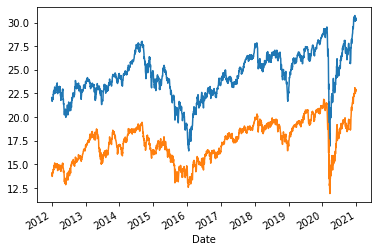

In [302]:
spy['Adj Close']['EWC'].plot()
spy['Adj Close']['EWA'].plot()

### Pearson Correlation

In [303]:
np.corrcoef(S1, S2)

array([[1.        , 0.93741391],
       [0.93741391, 1.        ]])

In [304]:
scipy.stats.pearsonr(S1,S2)

(0.9374139137982568, 0.0)

### Stationarity

In [305]:
stationarity(S1)

The series is NOT stationary
p-value =  0.06313859943198726


In [306]:
stationarity(S2)

The series is NOT stationary
p-value =  0.1831812652897578


### Cointegration

In [307]:
cointegration(S1,S2)

The series are cointegrated
p-value =  0.0003932992307013673


#Explore DF

In [308]:
df = pd.DataFrame(columns=['S1', 'S2'])

In [309]:
# Trying to make time series stationary in some way... trying log diff of prices and simple ratio of prices
# Then calculating 2 stdev bands, to see if asset prices revert to mean after exceeding 2 or 2.5 stdev up or down


df['S1']= S1.tolist()
df['S2']= S2.tolist()
df['s1_log'] = np.log(df['S1'] / df['S1'].shift(1))
df['s2_log'] = np.log(df['S2'] / df['S2'].shift(1))
df['log_ratio'] = df['s2_log'] / df['s1_log'] 
df['ratio'] = df['S2'] / df['S1']

window = 90

df['log_30_mean'] = df['log_ratio'].rolling(window=window).mean()
df['log_30_std'] = df['log_ratio'].rolling(window=window).std()

df['30_mean'] = df['ratio'].rolling(window=window).mean()
df['30_std'] = df['ratio'].rolling(window=window).std()


df['up_2'] = df['30_mean'] + (df['30_std'] * 2.)
df['down_2'] = df['30_mean'] - (df['30_std'] * 2.)
df['up_1'] = df['30_mean'] + (df['30_std'] * 1)
df['down_1'] = df['30_mean'] - (df['30_std'] * 1)

df['log_up_2'] = df['log_30_mean'] + (df['log_30_std'] * 6)
df['log_down_2'] = df['log_30_mean'] - (df['log_30_std'] * 6)



df.fillna(0, inplace=True)

In [310]:
df.head(3)

,S1,S2,s1_log,s2_log,log_ratio,ratio,log_30_mean,log_30_std,30_mean,30_std,up_2,down_2,up_1,down_1,log_up_2,log_down_2
0,22.073177,13.932520,0.000000,0.000000,0.000000,0.631197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.032898,14.096581,-0.001826,0.011707,-6.409409,0.639797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21.895952,13.913589,-0.006235,-0.013066,2.095679,0.635441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


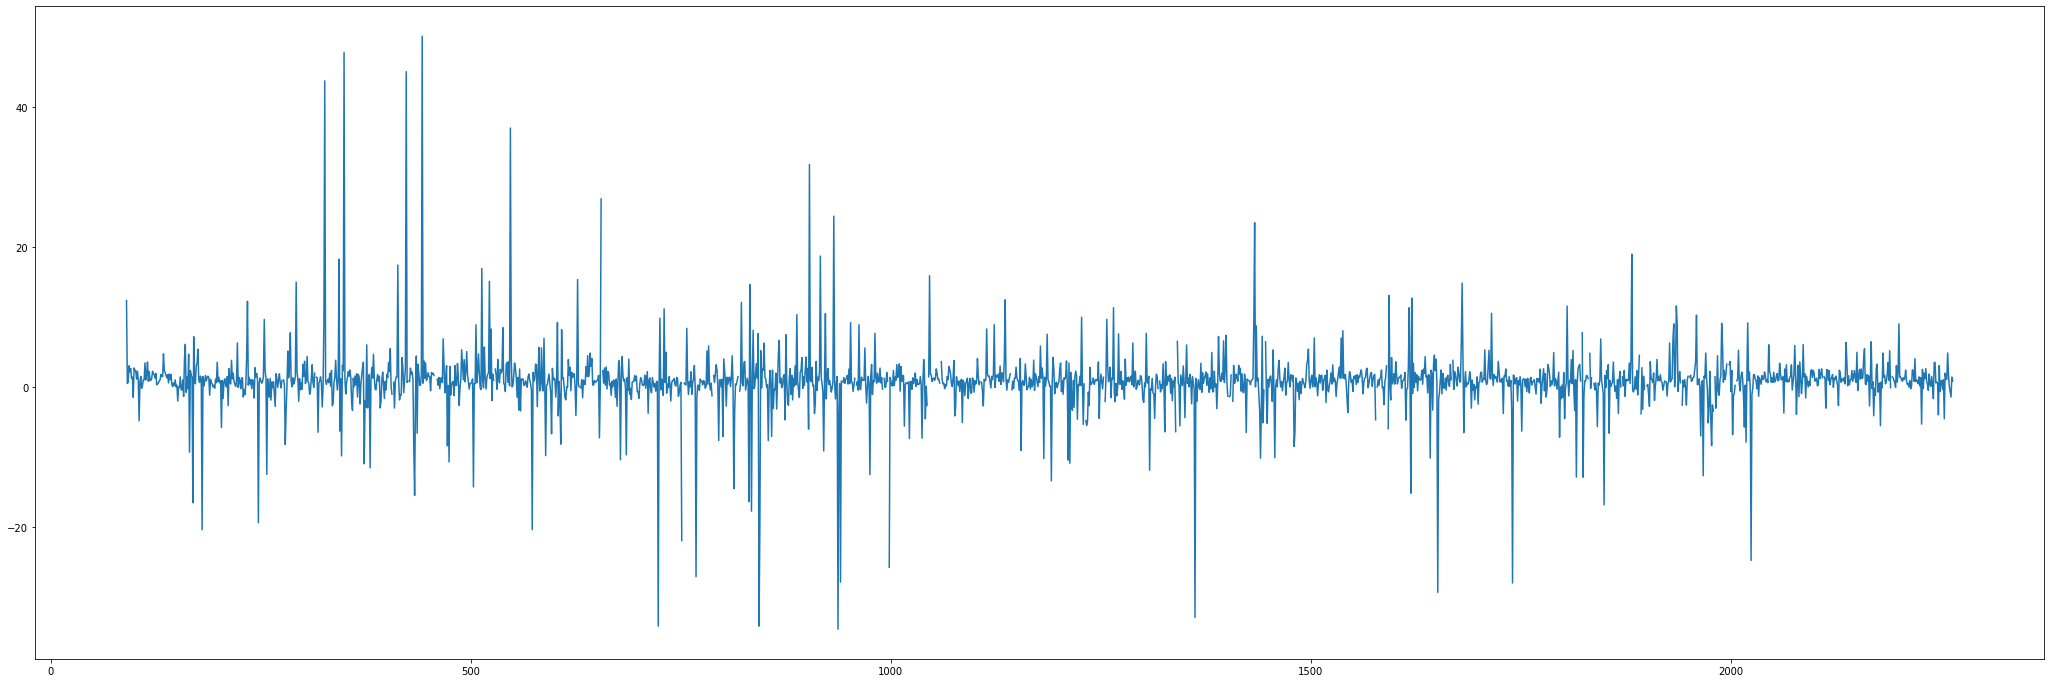

In [311]:
plt.figure(figsize=(36, 12))


df['log_ratio'][90:].plot()

# df['ratio'][60:].plot()
# df['30_mean'][60:].plot()
# df['log_up_2'][90:].plot()
# df['log_down_2'][90:].plot()


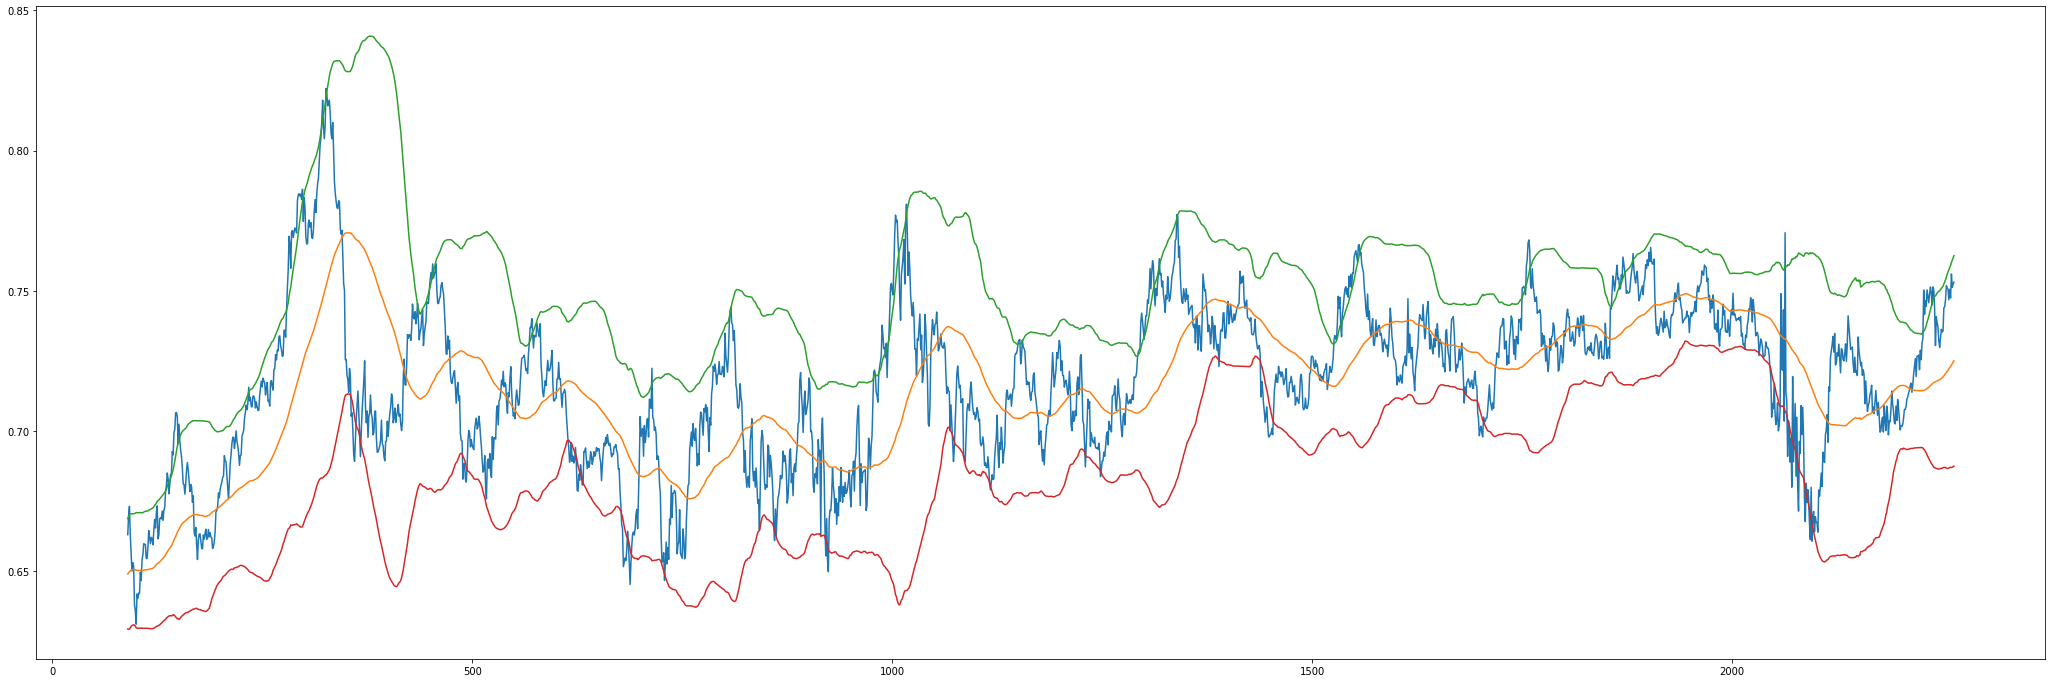

In [312]:
plt.figure(figsize=(36, 12))


df['ratio'][90:].plot()


df['30_mean'][90:].plot()
df['up_2'][90:].plot()
df['down_2'][90:].plot()


# df['up_1'][60:].plot()
# df['down_1'][60:].plot()